In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

np.random.seed(42)

In [2]:
data = datasets.load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (569, 30) y shape: (569,)


In [3]:
if not np.issubdtype(np.array(y).dtype, np.number):
    y = LabelEncoder().fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
print("PCA 2D shape:", X_2d.shape)

PCA 2D shape: (569, 2)


In [5]:
X_full_train, X_full_test, X_vis_train, X_vis_test, y_train, y_test = train_test_split(
    X_scaled, X_2d, y, test_size=0.30, random_state=42, stratify=y
)
print("Train sizes:", X_full_train.shape, X_vis_train.shape, y_train.shape)
print("Test sizes:", X_full_test.shape, X_vis_test.shape, y_test.shape)

Train sizes: (398, 30) (398, 2) (398,)
Test sizes: (171, 30) (171, 2) (171,)


In [6]:
svc_linear_full = SVC(kernel='linear', C=1.0, random_state=42)
svc_linear_full.fit(X_full_train, y_train)
y_pred_lin = svc_linear_full.predict(X_full_test)

print("Linear SVM (full) Accuracy:", accuracy_score(y_test, y_pred_lin))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lin))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lin))

Linear SVM (full) Accuracy: 0.9824561403508771

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98        64
           1       0.98      0.99      0.99       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Confusion Matrix:
 [[ 62   2]
 [  1 106]]


In [7]:
svc_rbf_full = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svc_rbf_full.fit(X_full_train, y_train)
y_pred_rbf = svc_rbf_full.predict(X_full_test)

print("RBF SVM (full) Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rbf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rbf))

RBF SVM (full) Accuracy: 0.9766081871345029

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        64
           1       0.98      0.98      0.98       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Confusion Matrix:
 [[ 62   2]
 [  2 105]]


In [8]:

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_full_train, y_train)

print("Best params from GridSearch:", grid.best_params_)
best_rbf = grid.best_estimator_

y_best = best_rbf.predict(X_full_test)
print("Best RBF test accuracy:", accuracy_score(y_test, y_best))
print(classification_report(y_test, y_best))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params from GridSearch: {'C': 10, 'gamma': 0.001}
Best RBF test accuracy: 0.9707602339181286
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        64
           1       0.96      0.99      0.98       107

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



In [9]:
best_C = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']

cv_model = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
cv_scores = cross_val_score(cv_model, X_scaled, y, cv=5, n_jobs=-1)
print("Cross-val scores:", cv_scores)
print("Mean CV accuracy: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))


Cross-val scores: [0.97368421 0.97368421 0.97368421 0.96491228 0.98230088]
Mean CV accuracy: 0.9737 ± 0.0055


In [12]:
sns.heatmap(confusion_matrix(y_test, y_pred_rbf), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (RBF Kernel)")
plt.show()

NameError: name 'sns' is not defined

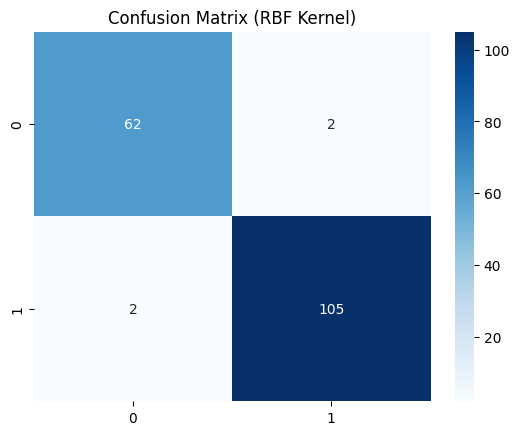

In [14]:
sns.heatmap(confusion_matrix(y_test, y_pred_rbf), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (RBF Kernel)")
plt.show()

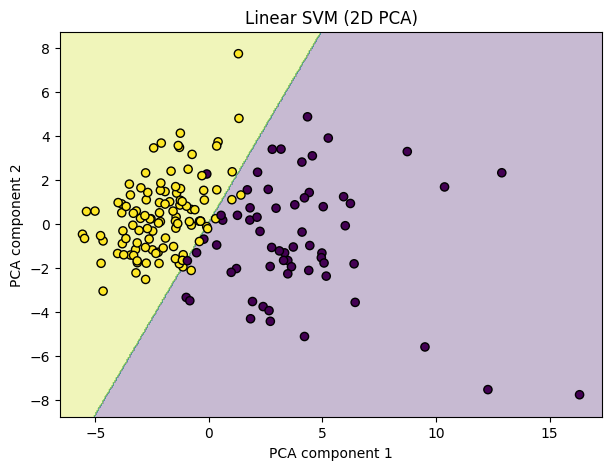

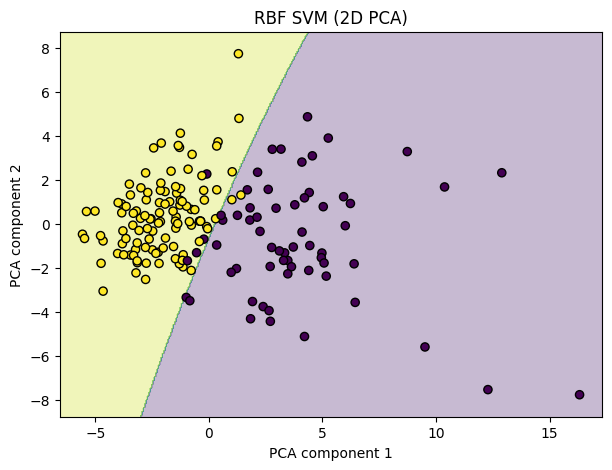

In [10]:
svc_lin_2d = SVC(kernel='linear', C=1.0)
svc_lin_2d.fit(X_vis_train, y_train)

svc_rbf_2d = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
svc_rbf_2d.fit(X_vis_train, y_train)
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', s=35)
    plt.title(title)
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.show()
plot_decision_boundary(svc_lin_2d, X_vis_test, y_test, "Linear SVM (2D PCA)")
plot_decision_boundary(svc_rbf_2d, X_vis_test, y_test, "RBF SVM (2D PCA)")


In [11]:
joblib.dump(best_rbf, 'svm_rbf_best.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca_2d.pkl')
print("Saved best_rbf, scaler, pca to files.")


Saved best_rbf, scaler, pca to files.
